In [ ]:
# load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 12178 (delta 50), reused 35 (delta 16), pack-reused 12086
Receiving objects: 100% (12178/12178), 13.49 MiB | 7.23 MiB/s, done.
Resolving deltas: 100% (8492/8492), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
%%shell

# download github repo for py file
git clone https://github.com/aliciachenw/11785-project.git
cd 11785-project

cp dataloader.py ../
cp model.py ../
cp train_teacher.py ../
cp coco_evaluate.py ../
cp self_training.py ../
cp train_teacher.py ../

Cloning into '11785-project'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 149 (delta 83), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (149/149), 4.25 MiB | 3.60 MiB/s, done.
Resolving deltas: 100% (83/83), done.


# **Parameters**

In [ ]:
import torch

NUM_WORKERS = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
NUM_EPOCHS = 20

TEACHER_TRAIN_LR = 0.0005
TEACHER_TRAIN_WEIGHT_DECAY = 5e-6
SEMI_TRAIN_LR = 0.001
SEMI_TRAIN_WEIGHT_DECAY = 5e-6

UNLABEL_LOSS_WEIGHT = 0.1
TRAINING_RATIO = 0.7
UNLABELED_LOSS_WEIGHT = 0.2
SCORE_THRESHOLD = 0.7
RELABEL_STEP = 3

print("use device:", DEVICE)

use device: cuda


In [ ]:
labeled_ratio = 0.3

# **custom dataset**

In [ ]:
from dataloader import FLIRDataset, get_dataloader, split_dataset

# **get dataset and dataloader**

In [ ]:
data_root_dir = '/content/gdrive/MyDrive/FLIR'
dataset = FLIRDataset(data_root_dir + '/train/', 'thermal_annotations.json')
# labeled_dataset = FLIRDataset(data_root_dir + '/train', 'split_dataset/labeled.json')
# unlabeled_dataset = FLIRDataset(data_root_dir + '/train', 'split_dataset/unlabeled.json')

/content/gdrive/MyDrive/FLIR/train/
/content/gdrive/MyDrive/FLIR/train/thermal_annotations.json


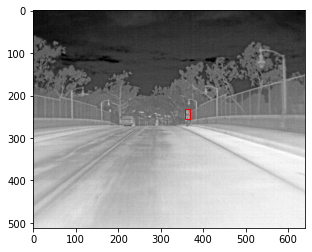

In [ ]:
from dataloader import check_dataloading
check_dataloading(dataset)

In [ ]:
# split training dataset into labeled and unlabeled
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from dataloader import collate_fn, split_dataset


In [ ]:
labeled_dataset, unlabeled_dataset = split_dataset(dataset, labeled_ratio)

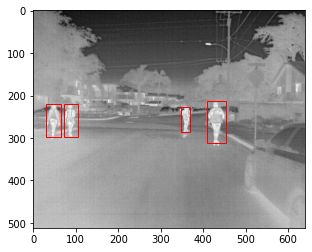

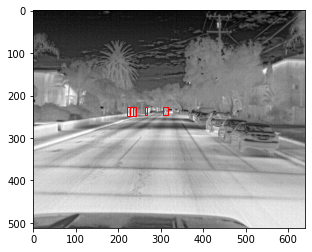

In [ ]:
from dataloader import check_dataloading
check_dataloading(labeled_dataset)
check_dataloading(unlabeled_dataset)

# **Get model**

In [ ]:
from model import get_model, save_checkpoint, load_checkpoint

# background and person
num_classes = 2
model = get_model(num_classes, pre_train=True)
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=TEACHER_TRAIN_LR, weight_decay=TEACHER_TRAIN_WEIGHT_DECAY)
lr_scheduler = None


# **Train teacher model**

In [ ]:
save_path = '/content/gdrive/MyDrive/FLIR/teacher_model-0.3-v2'
import os
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [ ]:
print(save_path)

/content/gdrive/MyDrive/FLIR/teacher_model-0.3-v2


In [ ]:
# load saved data
import pickle
dataset_path = os.path.join(save_path, 'dataset')
with open(os.path.join(dataset_path, 'labeled_dataset.pickle'), 'rb') as handle:
  labeled_dataset = pickle.load(handle)
with open(os.path.join(dataset_path, 'unlabeled_dataset.pickle'), 'rb') as handle:
  unlabeled_dataset = pickle.load(handle)

In [ ]:
# save dataset
import os
dataset_path = os.path.join(save_path, 'dataset')
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
import pickle
with open(os.path.join(dataset_path, 'labeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(labeled_dataset, handle, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dataset_path, 'unlabeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(unlabeled_dataset, handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
import math
import sys
import time
import torch
import transforms as T
import utils
from model import save_checkpoint, load_checkpoint
from dataloader import collate_fn, split_dataset
from torch.utils.data import DataLoader
import numpy as np

all_validation_loss = []
all_training_loss = []

def train_teacher_model(model, labeled_dataset, optimizer, scheduler=None, train_ratio=0.7, batch_size=4, device='cpu', max_epochs=100, print_freq=10, save_path=None, checkpoint=None):
    model.to(device)
    metric_logger = utils.MetricLogger(delimiter=" ")
    last_loss = 1e9


    cur_epoch = 0
    if checkpoint is not None:
        print("loading checkpoint:" + checkpoint)
        model, optimizer, scheduler, cur_epoch = load_checkpoint(model, optimizer, scheduler, device, checkpoint)

    train_dataset, vld_dataset = split_dataset(labeled_dataset, train_ratio)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    vld_loader = DataLoader(vld_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    for epoch in range(cur_epoch, max_epochs):
        print("epoch {} / {}".format(epoch + 1, max_epochs))
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq)
        loss = evaluate(model, vld_loader, device, epoch, print_freq)
        print("training loss {} validation loss {}".format(train_loss, loss))
        if loss < last_loss and save_path != None:
            save_checkpoint(model, optimizer, scheduler, epoch + 1, device, save_path)
            last_loss = loss
        elif save_path != None:
            save_checkpoint(model, optimizer, scheduler, epoch + 1, device, save_path)
        if scheduler is not None:
            scheduler.step()
        all_validation_loss.append(loss)
        all_training_loss.append(train_loss)


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    all_loss = []
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        all_loss.append(losses.item())


        # loss in original paper
        # losses = loss_dict['loss_classifier'] + loss_dict['loss_box_reg']
        # losses_reduced = loss_dict_reduced['loss_classifier'] + loss_dict_reduced['loss_box_reg']

        loss_value = losses_reduced.item()

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        if device == 'cuda':
            torch.cuda.empty_cache()
            del images
            del targets
            del losses_reduced
            del losses
            del loss_dict
            del loss_dict_reduced
        # break
    return np.mean(all_loss)


def evaluate(model, data_loader, device, epoch, print_freq):  # test overfitting
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Validation'.format(epoch)
    sum_loss = []

    with torch.no_grad():
        for images, targets in metric_logger.log_every(data_loader, print_freq, header):
            # for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # reduce losses over all GPUs for logging purposes
            loss_dict_reduced = utils.reduce_dict(loss_dict)
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            # loss in origin paper
            # losses_reduced = loss_dict_reduced['loss_classifier'] + loss_dict_reduced['loss_box_reg']
            # losses = loss_dict['loss_classifier'] + loss_dict['loss_box_reg']
            if math.isfinite(losses.item()):
                sum_loss.append(losses.item())

            loss_value = losses_reduced.item()

            metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

            if device == 'cuda':
                torch.cuda.empty_cache()
                del images
                del targets
                del losses_reduced
                del losses
                del loss_dict
                del loss_dict_reduced
            # break
    sum_loss = np.mean(sum_loss)
    return sum_loss


In [ ]:
# from train_teacher import train_teacher_model

train_teacher_model(model, labeled_dataset, optimizer, lr_scheduler, 
                    train_ratio=TRAINING_RATIO, batch_size=BATCH_SIZE, device=DEVICE, 
                    max_epochs=20, print_freq=100, save_path=save_path)

In [ ]:
import numpy as np
np.savez(os.path.join(save_path, "train_loss.npz"), train_loss=np.array(all_training_loss), val_loss=np.array(all_validation_loss))
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_training_loss)
plt.plot(all_validation_loss)

# evaluation on teacher model

In [ ]:
# load the best teacher model
checkpoint = '/content/gdrive/MyDrive/FLIR/teacher_model-0.3/0008.tar'
model, optimizer, lr_scheduler, _ = load_checkpoint(model, optimizer, lr_scheduler, DEVICE,checkpoint)

In [ ]:
test_dataset = FLIRDataset(data_root_dir + '/val/', 'thermal_annotations.json')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

/content/gdrive/MyDrive/FLIR/val/
/content/gdrive/MyDrive/FLIR/val/thermal_annotations.json


In [ ]:
from coco_evaluate import coco_evaluate
coco_evaluate(model, test_dataloader, DEVICE)

creating index...
index created!
Test:  [  0/151]  eta: 0:01:39  model_time: 0.4893 (0.4893)  evaluator_time: 0.1048 (0.1048)  time: 0.6604  data: 0.0628  max mem: 7726
Test:  [100/151]  eta: 0:00:32  model_time: 0.4756 (0.4762)  evaluator_time: 0.0696 (0.0980)  time: 0.6256  data: 0.0596  max mem: 7726
Test:  [150/151]  eta: 0:00:00  model_time: 0.4755 (0.4754)  evaluator_time: 0.0785 (0.0913)  time: 0.6139  data: 0.0561  max mem: 7726
Test: Total time: 0:01:35 (0.6292 s / it)
Averaged stats: model_time: 0.4755 (0.4754)  evaluator_time: 0.0785 (0.0913)
Accumulating evaluation results...
DONE (t=0.80s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

In [ ]:
# save dataset
import os
dataset_path = os.path.join(save_path, 'dataset')
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
import pickle
with open(os.path.join(dataset_path, 'labeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(labeled_dataset, handle, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dataset_path, 'unlabeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(unlabeled_dataset, handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
# visualize the performance
import random
model.eval()
image, target = test_dataset.__getitem__(random.randint(0, test_dataset.__len__() - 1))
predict = model([image.to(DEVICE)])
predict = predict[0]

import matplotlib.pyplot as plt
import matplotlib.patches as patches
image = image[0, :, :].to('cpu').detach().numpy()
fig, ax = plt.subplots(1)
box = predict["boxes"]
index = predict["scores"] > 0.5
box = box[index, :].to('cpu').detach().numpy()
ax.imshow(image, cmap='gray')
for i in range(box.shape[0]):
  rect = patches.Rectangle((box[i, 0], box[i, 1]), box[i, 2] - box[i, 0], box[i, 3] - box[i, 1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
print(target["boxes"])
print(predict["boxes"])
plt.show()
print(predict["scores"][index])


# **Self training**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# load saved data
import pickle
dataset_path = os.path.join(save_path, 'dataset')
with open(os.path.join(dataset_path, 'labeled_dataset.pickle'), 'rb') as handle:
  labeled_dataset = pickle.load(handle)
with open(os.path.join(dataset_path, 'unlabeled_dataset.pickle'), 'rb') as handle:
  unlabeled_dataset = pickle.load(handle)

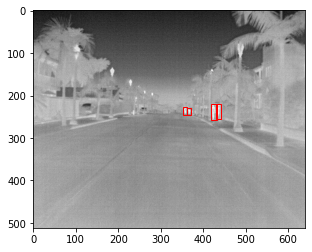

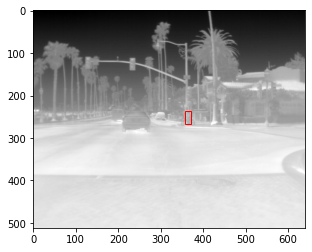

In [ ]:
from dataloader import check_dataloading
check_dataloading(labeled_dataset)
check_dataloading(unlabeled_dataset)

In [ ]:
save_self_training_path = '/content/gdrive/MyDrive/FLIR/self_training-0.3-ensemble-weight0.2-score0.7-relabel-3'

In [ ]:
save_self_training_path = '/content/gdrive/MyDrive/FLIR/self_training-0.3-ensemble-weight0.2-score0.7-relabel-3'
train_labeled_dataset, val_labeled_dataset = split_dataset(labeled_dataset, TRAINING_RATIO)
train_unlabeled_dataset, val_unlabeled_dataset = split_dataset(unlabeled_dataset, TRAINING_RATIO)
# save dataset
import os
dataset_path = os.path.join(save_self_training_path, 'dataset')
if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)
import pickle
with open(os.path.join(dataset_path, 'train_labeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(train_labeled_dataset, handle, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dataset_path, 'val_labeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(val_labeled_dataset, handle, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dataset_path, 'train_unlabeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(train_unlabeled_dataset, handle, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(dataset_path, 'val_unlabeled_dataset.pickle'), 'wb') as handle:
  pickle.dump(val_unlabeled_dataset, handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
import math
import sys
import time
import torch
import transforms as T
import utils
from model import save_checkpoint, load_checkpoint
from dataloader import collate_fn, split_dataset, FLIRPseudoDataset, convert_subset
from torch.utils.data import DataLoader
import numpy as np
from coco_evaluate import coco_evaluate
import pickle

all_training_loss = []
all_evaluation_loss = []

def self_training(model, labeled_dataset, unlabeled_dataset, optimizer, scheduler=None, batch_size=4, train_ratio=0.7, score_threshold=0.7, unlabeled_loss_weight=0.1, relabel_step=None,
                  device='cpu', max_epochs=100, print_freq=10, save_path=None, checkpoint=None):
    model.to(device)
    metric_logger = utils.MetricLogger(delimiter=" ")
    last_loss = 1e9

    cur_epoch = 0
    # train_labeled_dataset, val_labeled_dataset = split_dataset(labeled_dataset, train_ratio)
    # train_unlabeled_dataset, val_unlabeled_dataset = split_dataset(unlabeled_dataset, train_ratio)
    dataset_path = os.path.join(save_path, 'dataset')

    if checkpoint is not None:
        print("loading checkpoint:" + checkpoint)
        model, optimizer, scheduler, cur_epoch = load_checkpoint(model, optimizer, scheduler, device, checkpoint)
    

    for epoch in range(cur_epoch, max_epochs):
        print("epoch {} / {}".format(epoch + 1, max_epochs))
        with open(os.path.join(dataset_path, 'train_labeled_dataset.pickle'), 'rb') as handle:
          train_labeled_dataset = pickle.load(handle)
        with open(os.path.join(dataset_path, 'val_labeled_dataset.pickle'), 'rb') as handle:
          val_labeled_dataset = pickle.load(handle)
        with open(os.path.join(dataset_path, 'train_unlabeled_dataset.pickle'), 'rb') as handle:
          train_unlabeled_dataset = pickle.load(handle)
        with open(os.path.join(dataset_path, 'val_unlabeled_dataset.pickle'), 'rb') as handle:
          val_unlabeled_dataset = pickle.load(handle)
          
        train_unlabeled_dataset = convert_subset(train_unlabeled_dataset)
        val_unlabeled_dataset = convert_subset(val_unlabeled_dataset)

        labeled_train_loader = DataLoader(train_labeled_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
        labeled_vld_loader= DataLoader(val_labeled_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
        pseudo_train = FLIRPseudoDataset(model, train_unlabeled_dataset, batch_size=batch_size, device=device, score_threshold=score_threshold)
        pseudo_val = FLIRPseudoDataset(model, val_unlabeled_dataset, batch_size=batch_size, device=device, score_threshold=score_threshold)
        unlabeled_train_loader = DataLoader(pseudo_train, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
        unlabeled_vld_loader= DataLoader(pseudo_val, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
        
        train_label_loss = train_one_epoch_self_training(model, optimizer, labeled_train_loader, 1, device, epoch, print_freq)
        train_loss = train_one_epoch_self_training(model, optimizer, unlabeled_train_loader, unlabeled_loss_weight, device, epoch, print_freq)
        train_loss = train_label_loss + unlabeled_loss_weight * train_loss
        all_training_loss.append(train_loss)

        coco_evaluate(model, labeled_vld_loader, device)
        # labeled_loss = evaluate(model, vld_loader, device, epoch, print_freq)
        coco_evaluate(model, unlabeled_vld_loader, device)
        # unlabeled_loss = evaluate(model, vld_loader, device, epoch, print_freq)

        # loss = labeled_loss + unlabeled_loss_weight * unlabeled_loss
        loss = 0
        all_evaluation_loss.append(loss)

        if save_path is not None:
            save_checkpoint(model, optimizer, scheduler, epoch + 1, device, save_path)
            last_loss = loss
        print("epoch {}, train loss {}, validation loss {}".format(epoch + 1, train_loss, loss))
            
        if scheduler is not None:
            scheduler.step()
        # if relabel_step != None:
        #     if epoch % relabel_step == 0 and epoch != 0:
        #         pseudo_train = FLIRPseudoDataset(model, train_unlabeled_dataset, batch_size=batch_size, device=device, score_threshold=score_threshold)
        #         pseudo_val = FLIRPseudoDataset(model, val_unlabeled_dataset, batch_size=batch_size, device=device, score_threshold=score_threshold)
        #         unlabeled_train_loader = DataLoader(pseudo_train, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
        #         unlabeled_vld_loader= DataLoader(pseudo_val, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

def train_one_epoch_self_training(model, optimizer, data_loader, weight, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    all_loss = []

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values()) * weight
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        all_loss.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        if device == 'cuda':
            torch.cuda.empty_cache()
            del images
            del targets
            del losses_reduced
            del losses
            del loss_dict
            del loss_dict_reduced
    return np.mean(all_loss)


In [ ]:

if not os.path.exists(save_self_training_path):
    os.makedirs(save_self_training_path)

optimizer = torch.optim.Adam(params, lr=SEMI_TRAIN_LR, weight_decay=SEMI_TRAIN_WEIGHT_DECAY)
lr_scheduler = None

self_training(model, labeled_dataset,unlabeled_dataset, optimizer, lr_scheduler, batch_size=BATCH_SIZE,
              train_ratio=TRAINING_RATIO, score_threshold=SCORE_THRESHOLD, unlabeled_loss_weight=UNLABELED_LOSS_WEIGHT, 
              relabel_step=RELABEL_STEP, device=DEVICE, max_epochs=50, print_freq=100, save_path=save_self_training_path)

In [ ]:
  with open(os.path.join(dataset_path, 'train_labeled_dataset.pickle'), 'rb') as handle:
    train_labeled_dataset = pickle.load(handle)
  with open(os.path.join(dataset_path, 'val_labeled_dataset.pickle'), 'rb') as handle:
    val_labeled_dataset = pickle.load(handle)
  with open(os.path.join(dataset_path, 'train_unlabeled_dataset.pickle'), 'rb') as handle:
    train_unlabeled_dataset = pickle.load(handle)
  with open(os.path.join(dataset_path, 'val_unlabeled_dataset.pickle'), 'rb') as handle:
    val_unlabeled_dataset = pickle.load(handle)

In [ ]:
torch.cuda.empty_cache()
batch_size = 8
device = 'cuda'
score_threshold = 0.9
pseudo = FLIRPseudoDataset(model, unlabeled_dataset, batch_size=batch_size, device=device, score_threshold=score_threshold)


In [ ]:
# visualize the performance
import random
model.eval()
image, target = labeled_dataset.__getitem__(random.randint(0, labeled_dataset.__len__() - 1))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
image = image[0, :, :].to('cpu').detach().numpy()
fig, ax = plt.subplots(1)
box = target["boxes"].to('cpu').detach().numpy()
ax.imshow(image, cmap='gray')
for i in range(box.shape[0]):
  rect = patches.Rectangle((box[i, 0], box[i, 1]), box[i, 2] - box[i, 0], box[i, 3] - box[i, 1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
print(target["boxes"])
plt.show()

# **COCO evaluation on self-trained model**

In [ ]:
# load the best teacher model
checkpoint = '/content/gdrive/MyDrive/FLIR/self_training-0.3-ensemble-weight0.2-score0.7-relabel-3/0001.tar'
model, optimizer, lr_scheduler, _ = load_checkpoint(model, optimizer, lr_scheduler, DEVICE,checkpoint)

In [ ]:
test_dataset = FLIRDataset(data_root_dir + '/val/', 'thermal_annotations.json')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

/content/gdrive/MyDrive/FLIR/val/
/content/gdrive/MyDrive/FLIR/val/thermal_annotations.json


In [ ]:
from coco_evaluate import coco_evaluate
coco_evaluate(model, test_dataloader, DEVICE)

creating index...
index created!
Test:  [  0/151]  eta: 0:01:08  model_time: 0.3219 (0.3219)  evaluator_time: 0.0702 (0.0702)  time: 0.4533  data: 0.0564  max mem: 7728
Test:  [100/151]  eta: 0:00:21  model_time: 0.2985 (0.2969)  evaluator_time: 0.0352 (0.0565)  time: 0.4105  data: 0.0578  max mem: 7728
Test:  [150/151]  eta: 0:00:00  model_time: 0.2973 (0.2964)  evaluator_time: 0.0426 (0.0514)  time: 0.3983  data: 0.0537  max mem: 7728
Test: Total time: 0:01:01 (0.4090 s / it)
Averaged stats: model_time: 0.2973 (0.2964)  evaluator_time: 0.0426 (0.0514)
Accumulating evaluation results...
DONE (t=0.55s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# visualize the performance
model.eval()
image, target = test_dataset.__getitem__(random.randint(0, test_dataset.__len__() - 1))
predict = model([image.to(DEVICE)])
predict = predict[0]

image = image[0, :, :].to('cpu').detach().numpy()
fig, ax = plt.subplots(1)
box = predict["boxes"]
index = predict["scores"] > 0.5
box = box[index, :].to('cpu').detach().numpy()
ax.imshow(image, cmap='gray')
for i in range(box.shape[0]):
  rect = patches.Rectangle((box[i, 0], box[i, 1]), box[i, 2] - box[i, 0], box[i, 3] - box[i, 1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
print(target["boxes"])

plt.show()
print(predict["scores"][index])